## Performance Analysis of Knowledge Representation Learning (KRL) on Linked Building Data (LBD)
The jupyter notebook below describes the technical implementation of Chapter 3 of the thesis and more specifically Section 4.1 (A study on training setup choices)

### 1. Create a virtual environment to install the project dependencies
The dependencies are listed in requirements.txt and the cell below will automatically create a virtual environment and install the dependencies. The virtual environment is running with python v3.9.13

In [ ]:
import os
import sys
import subprocess
import platform

# Step 1: Create a virtual environment
venv_dir = '../.venv'  # Name of your virtual environment directory
if platform.system() == 'Windows':
    subprocess.check_call(['py', '-m', 'venv', venv_dir])
else:
    subprocess.check_call([sys.executable, '-m', 'venv', venv_dir])

# Step 2: Check the OS and set paths
if platform.system() == 'Windows':
    pip_executable = os.path.join(venv_dir, 'Scripts', 'pip')
else:
    pip_executable = os.path.join(venv_dir, 'bin', 'pip')

# Step 3: Install dependencies from requirements.txt
requirements_path = '../requirements.txt'  # Path to your requirements.txt

# Install the dependencies
subprocess.check_call([pip_executable, 'install', '-r', requirements_path])

# Output instructions for activating the virtual environment
print("Run the printed command below in your terminal to activate the virtual environment")
if platform.system() == 'Windows':
    print(f'.venv\Scripts\\activate')
else:
    print(f'source .venv/bin/activate')

### 2. Import project dependencies

In [16]:
import os
import argparse
import pandas as pd
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import matplotlib.pyplot as plt
import seaborn as sns
from rdflib import Graph, URIRef, Literal, RDF
import yaml
import json
from matplotlib import font_manager
from collections import Counter
import networkx as nx

### 3. Setup a utility function to load the experimentation configuration file (YAML)

In [3]:
def load_config(config_path: str) -> dict:
    """Load a YAML config file"""

    with open(config_path, "r", encoding="utf-8") as file:
        config = yaml.safe_load(file)

    return config

### 4. Setup utility functions for converting the input BIM-KG datasets from TURTLE to TSV

In [4]:
# Function to convert turtle KG file to TSV
def turtle_to_tsv(input_file, output_file):
    # Load the Turtle file into an RDFLib Graph
    g = Graph()
    g.parse(input_file, format='turtle')

    # Open the TSV file for writing
    with open(output_file, 'w') as tsvfile:
        # Iterate over triples and write them to the TSV file
        for subj, pred, obj in g:
            tsvfile.write(f"{subj}\t{pred}\t{obj}\n")

In [5]:

def convert_all_datasets(root_folder):
    """Iterate over each dataset folder and convert Turtle files to TSV."""
    # Get a list of all dataset directories in the root folder
    dataset_dirs = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    # Loop through each dataset directory
    for dataset in dataset_dirs:
        dataset_path = os.path.join(root_folder, dataset)
        input_ttl = os.path.join(dataset_path, 'input.ttl')
        output_tsv = os.path.join(dataset_path, 'input.tsv')

        if os.path.exists(input_ttl):
            print(f"Converting {input_ttl} to {output_tsv}...")
            turtle_to_tsv(input_ttl, output_tsv)
        else:
            print(f"No input.ttl found in {dataset_path}")

    print("Conversion complete for all datasets!")

### 5. Specify the datasets folder and perform the TTL --> CSV conversion

In [6]:
# Generate TSV files for all dataset files
root_folder = './datasets'
convert_all_datasets(root_folder)

Converting ./datasets/soda-hall/input.ttl to ./datasets/soda-hall/input.tsv...
Converting ./datasets/rice-hall/input.ttl to ./datasets/rice-hall/input.tsv...
Conversion complete for all datasets!


### 6. Setup a utility function for generating file names for the result artifacts from the experiments

In [8]:
# Function to generate experiment name from experiment configuration - useful to saving artifacts
def generate_experiment_name(model_name, optimizer_name, loss_function, create_inverse):
    """Generate a unique experiment name based on the combination of parameters"""
    return f"{model_name}_{optimizer_name}_{loss_function}_{'with_inverse' if create_inverse else 'without_inverse'}"

### 7. Define the utility function to run the experiments studying the training setup choices and save the result artifacts

In [9]:
# Fun to run experiments
def run_baseline(config: dict) -> None:
    """Run a Baseline Model With Default Parameters"""

    dataset_dirs = config["datasets"]["dirs"]  # Assuming you list all dataset directories in the config
    
    # Initialize an empty DataFrame to store experiment results
    experiment_results = pd.DataFrame(columns=['model', 'optimizer', 'loss', 'inverse', 'hits@10'])

    for dataset_dir in dataset_dirs:
        dataset_name = os.path.basename(dataset_dir)  # Get the dataset folder name (e.g., rice-hall)
        dataset_path = os.path.join(dataset_dir, 'input.tsv')

        for model in config["models"]:
            for optimizer in config["optimizers"]:
                for loss_function in config["training"]["loss_function"]:
                    for create_inverse in config["training"]["create_inverse"]:
                        experiment_name = generate_experiment_name(model["name"], optimizer["class"], loss_function, create_inverse)
                        experiment_path = os.path.join(config["save"]["path"], dataset_name, experiment_name)

                        tf = TriplesFactory.from_path(dataset_path, create_inverse_triples=create_inverse)
                        training, testing, validation = tf.split([.8, .1, .1])

                        # Optionally create the directory if it does not exist
                        os.makedirs(experiment_path, exist_ok=True)
                        
                        pipeline_result = pipeline(
                            training=training,
                            testing=testing,
                            validation=validation,
                            loss=loss_function,
                            model=model["name"],
                            model_kwargs={
                                "embedding_dim": model["embedding_dim"],
                                "random_seed": config["seed"],
                            },
                            training_loop="sLCWA",
                            training_kwargs={
                                "num_epochs": config["training"]["num_epoch"],
                            },
                            optimizer=optimizer["class"],
                            optimizer_kwargs={"lr": optimizer["lr"]},
                            negative_sampler_kwargs={
                                "num_negs_per_pos": config["training"]["num_negative"],
                            },
                            random_seed=config["seed"],
                            evaluator_kwargs={"filtered": True},
                            use_testing_data=False,
                            use_tqdm=False
                        )

                        # Save hits@10 to the DataFrame
                        experiment_results = experiment_results.append({
                            'model': model["name"],
                            'optimizer': optimizer["class"],
                            'loss': loss_function,
                            'inverse': 'with_inverse' if create_inverse else 'without_inverse',
                            'hits@1': pipeline_result.get_metric("hits_at_1"),
                            'hits@3': pipeline_result.get_metric("hits_at_3"),
                            'hits@5': pipeline_result.get_metric("hits_at_5"),
                            'hits@10': pipeline_result.get_metric("hits_at_10"),
                        }, ignore_index=True)

                        pipeline_result.save_to_directory(experiment_path)

        # Export experiment results to CSV file
        experiment_results.to_csv(os.path.join(config["save"]["path"], dataset_name, 'experiment_results.csv'), index=False)


### 8. Specify the configuration path and run the experiments

In [ ]:
# Directly assign the path to your YAML configuration file here
config_path = './config.yaml'

run_config = load_config(config_path)

assert run_config["type"] == "baseline", "Incorrect Config Type"

run_baseline(run_config)

### 9. Summarize the results artifacts into CSV files for analysis

In [11]:
# Step 1: Identify all dataset folders
results_path = './results/'  # Adjust this path to your results directory
dataset_dirs = [d for d in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, d))]
print(dataset_dirs)

['soda-hall', 'rice-hall']


In [14]:


# Loop through each dataset directory
for dataset_dir in dataset_dirs:
    dataset_path = os.path.join(results_path, dataset_dir)

    # Initialize a DataFrame to hold the training setup summary for this dataset
    training_setup_summary = pd.DataFrame(columns=['model', 'optimizer', 'loss', 'inverse_relations', 'hits@1', 'hits@3', 'hits@5', 'hits@10'])

    # Identify all model result folders within the dataset directory
    model_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    # Loop through each model directory to extract information
    for model_dir in model_dirs:
        model, optimizer, loss, inverse_relations, inverse_relations2 = model_dir.rsplit('_', 4,)
        raw_results_dir = os.path.join(results_path, dataset_dir, model_dir, 'results.json')

        if os.path.exists(raw_results_dir):
            # Read and parse the JSON file
            with open(raw_results_dir, 'r') as file:
                data = json.load(file)
                training_setup_summary = training_setup_summary.append({
                                    'model': model,
                                    'optimizer': optimizer,
                                    'loss': loss,
                                    'inverse_relations': True if inverse_relations == 'with' else False,
                                    'hits@1': data["metrics"]["both"]["realistic"]["hits_at_1"],
                                    'hits@3': data["metrics"]["both"]["realistic"]["hits_at_3"],
                                    'hits@5': data["metrics"]["both"]["realistic"]["hits_at_5"],
                                    'hits@10': data["metrics"]["both"]["realistic"]["hits_at_10"],}, ignore_index=True)

    training_setup_summary_path = os.path.join(dataset_path, 'training_setup_summary.csv')
    training_setup_summary.to_csv(training_setup_summary_path, index=False)

    print(f"Summary CSVs saved for dataset: {dataset_dir}")

Summary CSVs saved for dataset: soda-hall
Summary CSVs saved for dataset: rice-hall


### 10. Generate plots

(Optional): Setup fonts for the generated plots (good for maintaining font consistency in the document where the plots will be embedded).

In [17]:
# Prepare fonts
font_dirs = ['/Users/kevin/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

font_manager.findfont("Linux Libertine")

'/Users/kevin/Library/Fonts/LinLibertine_R.ttf'

Get paths to the two data sets and also define dataset titles for labelling plots

In [20]:
# Paths to the two datasets
graph_paths = ["./datasets/rice-hall/input.ttl", "./datasets/soda-hall/input.ttl"]
dataset_titles = ["Rice Hall Dataset", "Soda Hall Dataset"]

Compute KG characteristics for both datasets i.e degree, average degree, KG density etc

In [21]:
# KG Characteristics - Compute Parameters

def compute_parameters(graph_path):
    # Load the Turtle file into an RDFLib Graph
    g = Graph()
    g.parse(graph_path, format="turtle")

    # Convert RDFLib Graph to NetworkX Graph
    G = nx.DiGraph()
    for s, p, o in g:
        if not isinstance(o, Literal):  # Exclude literal objects to focus on entity relationships
            G.add_edge(str(s), str(o))

    # Relationship Density using NetworkX
    relationship_density_nx = nx.density(G)

    # Entity Heterogeneity
    entity_types = {o for _, o in g.subject_objects(RDF.type)}
    num_unique_types = len(entity_types)

    degrees = [G.degree(n) for n in G.nodes()]
    degree_distribution = nx.degree_histogram(G)

    # Calculate average degree
    average_degree = sum(degrees) / len(G.nodes())


    # Average Degree Connectivity
    avg_degree_connectivity = nx.average_degree_connectivity(G)

    return relationship_density_nx, num_unique_types, avg_degree_connectivity, average_degree

# Compute parameters for each dataset
for graph_path, dataset_title in zip(graph_paths, dataset_titles):
    
    print(f"Dataset: {dataset_title}")
    relationship_density_nx, entity_heterogeneity, avg_degree_connectivity, average_degree = compute_parameters(graph_path)
    print(f"KG Density: {relationship_density_nx}")
    print(f"Average Degree: {average_degree}")
    print(f"Entity Heterogeneity: {entity_heterogeneity} unique types")
    print(f"Average Degree Connectivity: {avg_degree_connectivity}")
    print()

Dataset: Rice Hall Dataset
KG Density: 0.0022646461871843
Average Degree: 3.6641975308641976
Entity Heterogeneity: 65 unique types
Average Degree Connectivity: {20: 8.8, 7: 36.410714285714285, 3: 36.419501133786845, 137: 0.0, 22: 11.954545454545455, 6: 40.455882352941174, 5: 33.75, 165: 0.0, 1: 19.214659685863875, 8: 13.6, 30: 5.933333333333334, 2: 67.96694214876032, 12: 0.0, 4: 41.5735294117647, 90: 0.0, 10: 14.128571428571428, 32: 8.71875, 9: 29.644444444444446, 59: 0.0, 56: 4.0, 17: 2.1372549019607843, 24: 11.770833333333334, 39: 0.0, 29: 0.0, 40: 7.8, 31: 11.516129032258064, 14: 0.0, 15: 16.866666666666667, 26: 10.115384615384615, 11: 10.863636363636363, 18: 15.555555555555555, 19: 11.789473684210526, 25: 3.38, 13: 0.0}

Dataset: Soda Hall Dataset
KG Density: 0.0012497904870174825
Average Degree: 4.341772151898734
Entity Heterogeneity: 36 unique types
Average Degree Connectivity: {111: 5.702702702702703, 6: 43.217948717948715, 3: 88.24589086127547, 243: 0.0, 48: 0.3125, 2: 97.51939

Plot: Degree Distribution (Fig 4.1a)

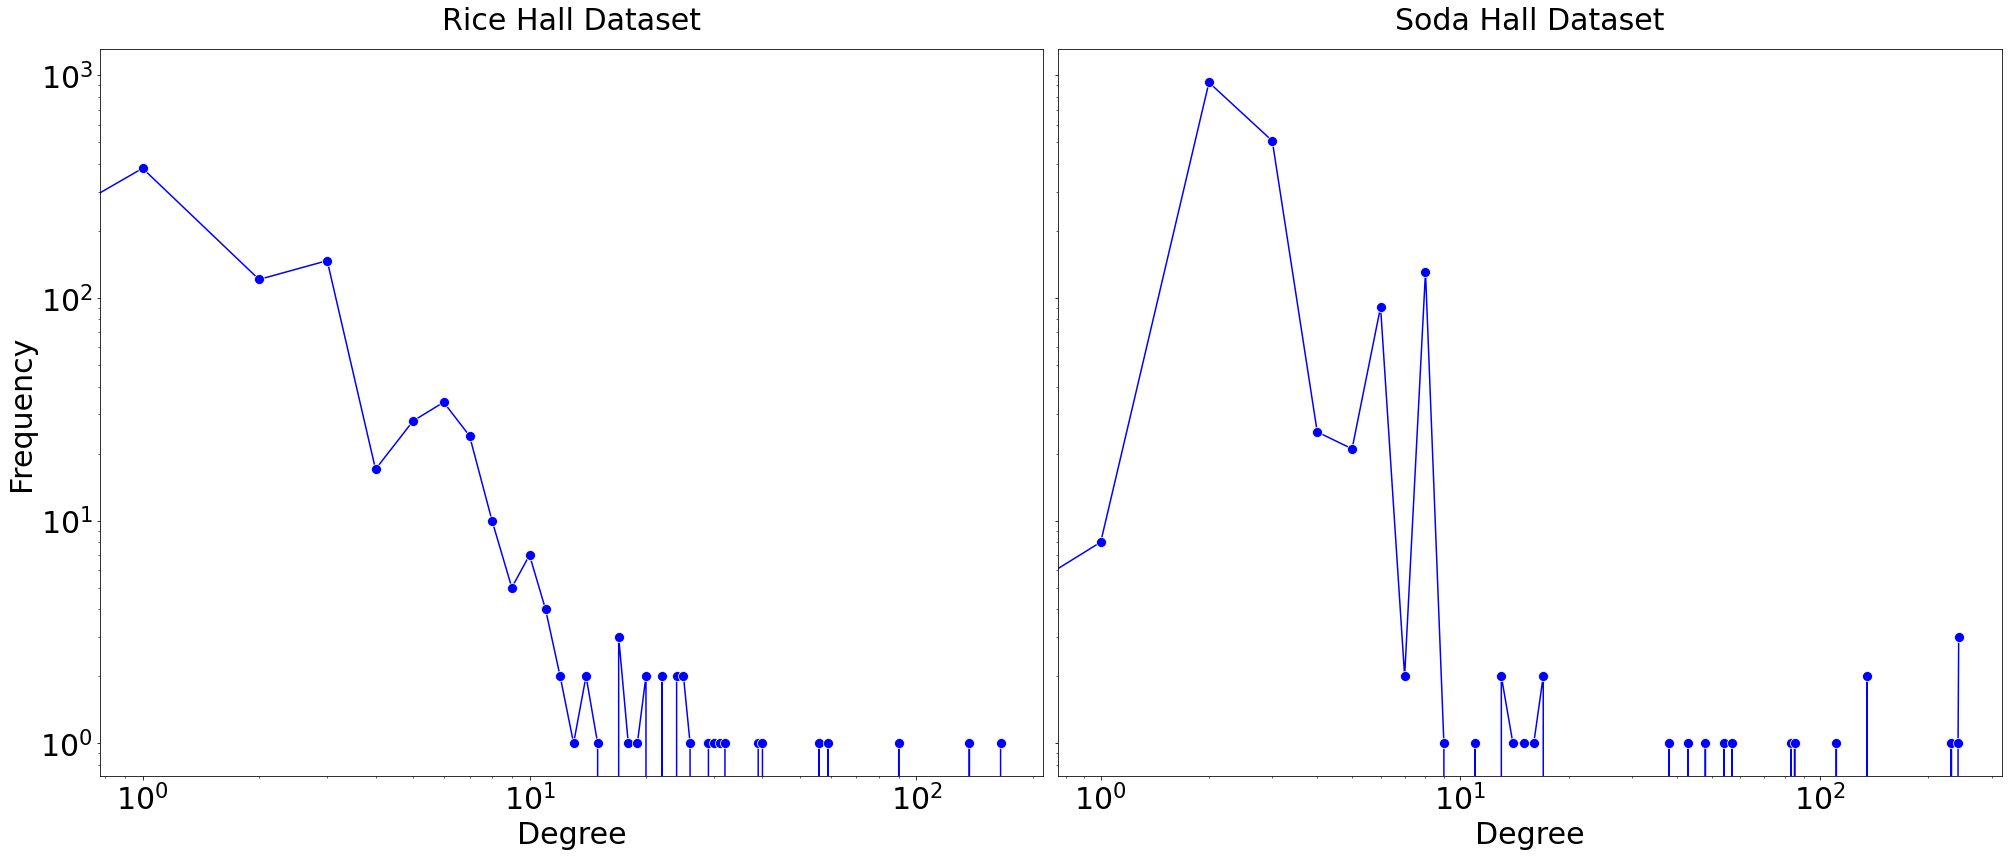

In [22]:
# KG Characteristics - Degree Distribution

def rdf_to_networkx_graph(graph_path):
    rdf_graph = Graph()
    rdf_graph.parse(graph_path, format="turtle")

    nx_graph = nx.DiGraph()

    for s, p, o in rdf_graph:
        if not isinstance(o, Literal):
            nx_graph.add_edge(str(s), str(o))

    num_nodes = nx_graph.number_of_nodes()
    num_edges = nx_graph.number_of_edges()

    return nx_graph, num_nodes, num_edges

def calculate_degree_distribution(nx_graph):
    degrees = [nx_graph.degree(n) for n in nx_graph.nodes()]
    degree_distribution = nx.degree_histogram(nx_graph)

    average_degree = sum(degrees) / len(degrees)

    return average_degree, degree_distribution

data = []
for graph_path, dataset_title in zip(graph_paths, dataset_titles):
    nx_graph, num_nodes, num_edges = rdf_to_networkx_graph(graph_path)
    average_degree, degree_distribution = calculate_degree_distribution(nx_graph)
    data.append((dataset_title, nx_graph, num_nodes, num_edges, average_degree, degree_distribution))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(28, 12), sharey=True)

for i, (dataset_title, _, _, _, _, degree_distribution) in enumerate(data):
    x_values = range(len(degree_distribution))
    y_values = degree_distribution
    sns.lineplot(x=x_values, y=y_values, ax=axes[i], marker='o', linestyle='-', color='b', markersize=10 )
    axes[i].set_title(f"{dataset_title}", fontsize=30, pad=20)
    axes[i].set_ylabel("Frequency", fontsize=30)
    axes[i].set_xlabel("Degree", fontsize=30)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].tick_params(axis='both', which='major', labelsize=30)
# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

plt.savefig('./plots/degree-distribution.eps', format='eps', bbox_inches='tight')
plt.tight_layout()
plt.show()


Utility function to process a Turtle file and calculate relation cardinality percentages. Also a plot for Relation cardinality types and relation patterns for both datasets (Fig 4.1b)

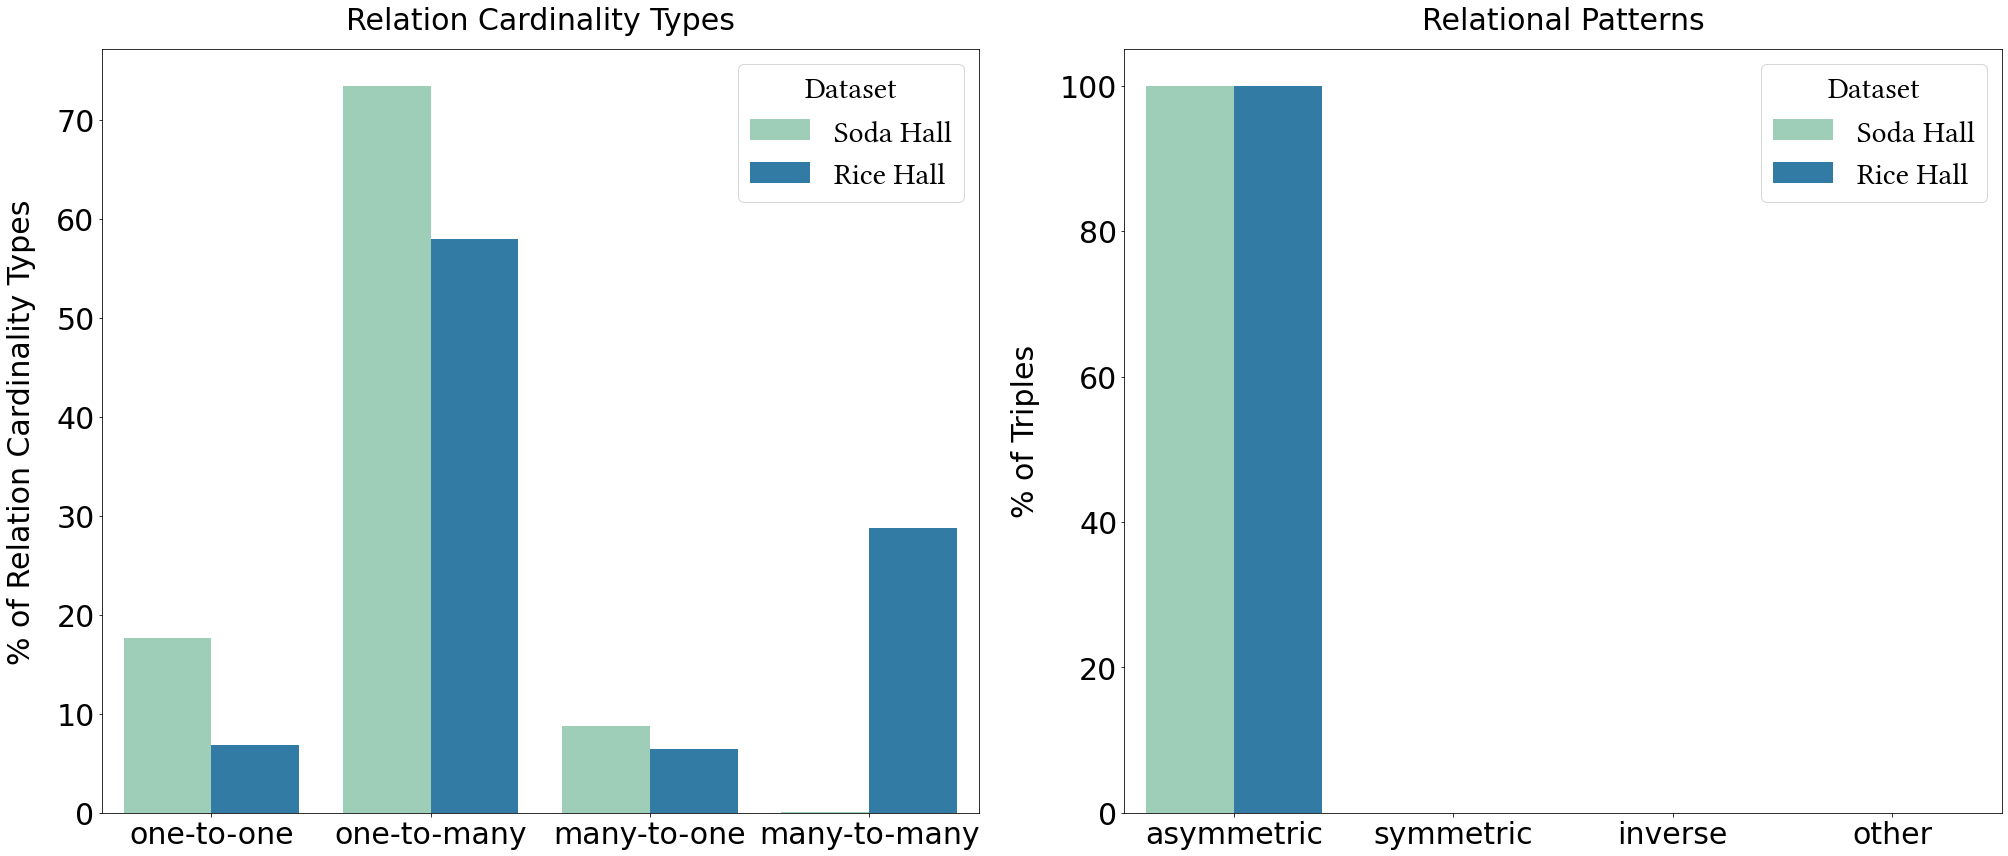

In [24]:
# Function to process a Turtle file and calculate relation cardinality percentages
def process_graph(file_path):
    g = Graph()
    g.parse(file_path, format="turtle")

    subject_to_object = {}
    object_to_subject = {}

    for s, p, o in g:
        if p not in subject_to_object:
            subject_to_object[p] = {}
        if p not in object_to_subject:
            object_to_subject[p] = {}

        if s not in subject_to_object[p]:
            subject_to_object[p][s] = set()
        subject_to_object[p][s].add(o)

        if o not in object_to_subject[p]:
            object_to_subject[p][o] = set()
        object_to_subject[p][o].add(s)

    relation_cardinality_counts = {"one-to-one": 0, "one-to-many": 0, "many-to-one": 0, "many-to-many": 0}

    for predicate, subjects in subject_to_object.items():
        for subject, objects in subjects.items():
            if len(objects) == 1:
                if all(len(object_to_subject[predicate].get(obj, [])) == 1 for obj in objects):
                    relation_cardinality_counts["one-to-one"] += 1
                else:
                    relation_cardinality_counts["one-to-many"] += 1
            else:
                if any(len(object_to_subject[predicate].get(obj, [])) > 1 for obj in objects):
                    relation_cardinality_counts["many-to-many"] += 1
                else:
                    relation_cardinality_counts["many-to-one"] += 1

    total_relations = sum(relation_cardinality_counts.values())
    percentages = {k: (v / total_relations * 100) for k, v in relation_cardinality_counts.items()}
    
    return percentages

# Function to calculate relation patterns
def calculate_patterns(graph_path):
    g = Graph()
    g.parse(graph_path, format="turtle")

    patterns = {"asymmetric": 0, "symmetric": 0, "inverse": 0, "other": 0}

    def is_inverse_relation(h, r, t, g):
        for r_inv in g.predicates(object=h, subject=t):
            if r_inv != r:
                return True
        return False

    for h, r, t in g:
        if (t, r, h) in g:
            patterns["symmetric"] += 1
        elif is_inverse_relation(h, r, t, g):
            patterns["inverse"] += 1
        elif (t, r, h) not in g:
            patterns["asymmetric"] += 1
        else:
            patterns["other"] += 1

    # Adjust for symmetrical and inverse relations being counted twice
    patterns["symmetric"] //= 2
    patterns["inverse"] //= 2

    total_patterns = sum(patterns.values())
    pattern_percentages = {key: (value / total_patterns * 100) for key, value in patterns.items()}
    
    return pattern_percentages

# Process both Turtle files
soda_cardinalities = process_graph("./datasets/soda-hall/input.ttl")
rice_cardinalities = process_graph("./datasets/rice-hall/input.ttl")

soda_patterns = calculate_patterns("./datasets/soda-hall/input.ttl")
rice_patterns = calculate_patterns("./datasets/rice-hall/input.ttl")

# Prepare DataFrames for Seaborn
cardinality_data = []
for relation_type, soda_percentage in soda_cardinalities.items():
    cardinality_data.append({"Relation Type": relation_type, "Percentage": soda_percentage, "Dataset": "Soda Hall"})
for relation_type, rice_percentage in rice_cardinalities.items():
    cardinality_data.append({"Relation Type": relation_type, "Percentage": rice_percentage, "Dataset": "Rice Hall"})

pattern_data = []
for pattern, soda_percentage in soda_patterns.items():
    pattern_data.append({"Pattern": pattern, "Percentage": soda_percentage, "Dataset": "Soda Hall"})
for pattern, rice_percentage in rice_patterns.items():
    pattern_data.append({"Pattern": pattern, "Percentage": rice_percentage, "Dataset": "Rice Hall"})

df_cardinality = pd.DataFrame(cardinality_data)
df_pattern = pd.DataFrame(pattern_data)

# Plotting with sns and subplots
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

sns.barplot(x="Relation Type", y="Percentage", hue="Dataset", data=df_cardinality, ax=axes[0], palette="YlGnBu")
axes[0].set_title("Relation Cardinality Types",fontsize=30, pad=20)
axes[0].set_ylabel("% of Relation Cardinality Types", fontsize=30,labelpad=20)
axes[0].set_xlabel("")
axes[0].legend(title='Dataset', title_fontproperties={'family':"Linux Libertine", 'size':30}, prop={'family':"Linux Libertine", 'size':30})

sns.barplot(x="Pattern", y="Percentage", hue="Dataset", data=df_pattern, ax=axes[1], palette="YlGnBu")
axes[1].set_title("Relational Patterns", fontsize=30, pad=20)
axes[1].set_ylabel("% of Triples", fontsize=30, labelpad=20)
axes[1].set_xlabel("")
axes[1].legend(title='Dataset', title_fontproperties={'family':"Linux Libertine", 'size':30}, prop={'family':"Linux Libertine", 'size':30})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/kg-characteristics.eps', format='eps', bbox_inches='tight')
plt.show()


Preprocess training-setup-summary data for plotting

In [25]:
experiment_results_rice = pd.read_csv('./results/rice-hall/training_setup_summary.csv')
experiment_results_soda = pd.read_csv('./results/soda-hall/training_setup_summary.csv')

melted_data_rice = experiment_results_rice.melt(
                      id_vars=['model', 'optimizer', 'loss', 'inverse_relations'],  # Keep these columns as identifiers
                      value_vars=['hits@1', 'hits@3', 'hits@5', 'hits@10'],  # These columns will be "melted"
                      var_name='metric',  # Name of the new column that holds the name of the melted columns
                      value_name='score')  # Name of the new column that holds the values of the melted columns

melted_data_soda = experiment_results_soda.melt(
                      id_vars=['model', 'optimizer', 'loss', 'inverse_relations'],  # Keep these columns as identifiers
                      value_vars=['hits@1', 'hits@3', 'hits@5', 'hits@10'],  # These columns will be "melted"
                      var_name='metric',  # Name of the new column that holds the name of the melted columns
                      value_name='score')  # Name of the new column that holds the values of the melted columns


df_rice = pd.DataFrame(melted_data_rice)
df_soda = pd.DataFrame(melted_data_soda)

# Replacement dictionary
replacement_dict = {
    'BCEWithLogitsLoss': 'BCEL',
    'SoftplusLoss': 'SPL',
    'MarginRankingLoss': 'MRL',
    'NSSALoss': 'NSSA'
}

# Applying the replacement
df_rice['loss'] = df_rice['loss'].replace(replacement_dict)
df_soda['loss'] = df_soda['loss'].replace(replacement_dict)

# Filter the data to include only Hits@1n(10) scores
hits_10_data_rice = melted_data_rice[melted_data_rice['metric'] == 'hits@10']
hits_10_data_soda = melted_data_soda[melted_data_soda['metric'] == 'hits@10']

Plot: Distribution of Hits@n scores across all categorial
training setup choices (Fig 4.2)

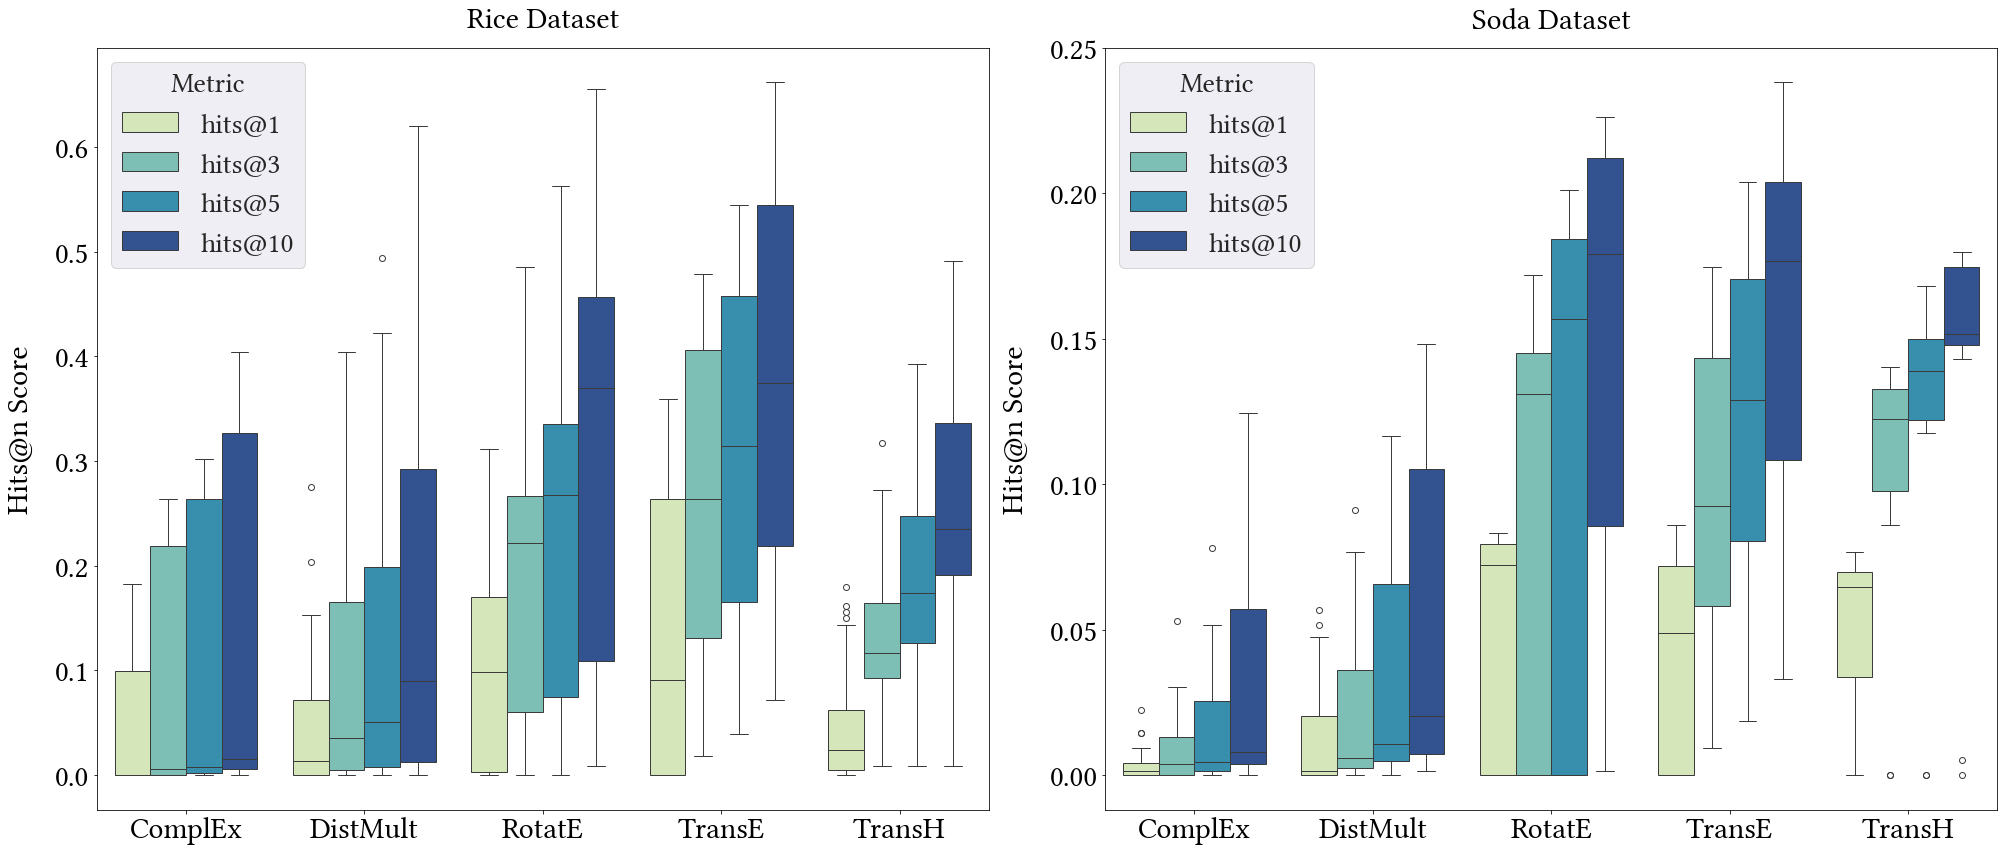

In [26]:
# Distribution of Hits@n Scores Across Models

plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.weight"] = "normal"

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(28, 12))  # 1 row, 2 columns

sns.set(style="darkgrid")

# Create a box plot
sns.boxplot(x='model', y='score', hue='metric', data=melted_data_rice, palette='YlGnBu', ax=axes[0])
axes[0].set_title('Rice Dataset', fontsize=30, pad=20,)
axes[0].set_xlabel('')
axes[0].set_ylabel('Hits@n Score', fontsize=30, labelpad=20)
axes[0].legend(title='Metric', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})


sns.boxplot(x='model', y='score', hue='metric', data=melted_data_soda, palette='YlGnBu', ax=axes[1])
axes[1].set_title('Soda Dataset', fontsize=30, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Hits@n Score', fontsize=30, labelpad=20)
axes[1].legend(title='Metric', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

# Your plotting code goes here
plt.savefig('./plots/hits@10_across_all_models.eps', format='eps', bbox_inches='tight')
plt.tight_layout()
plt.show()

Plot: Distribution of Hits@10 scores across all models and optimizers (Fig 4.3a)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


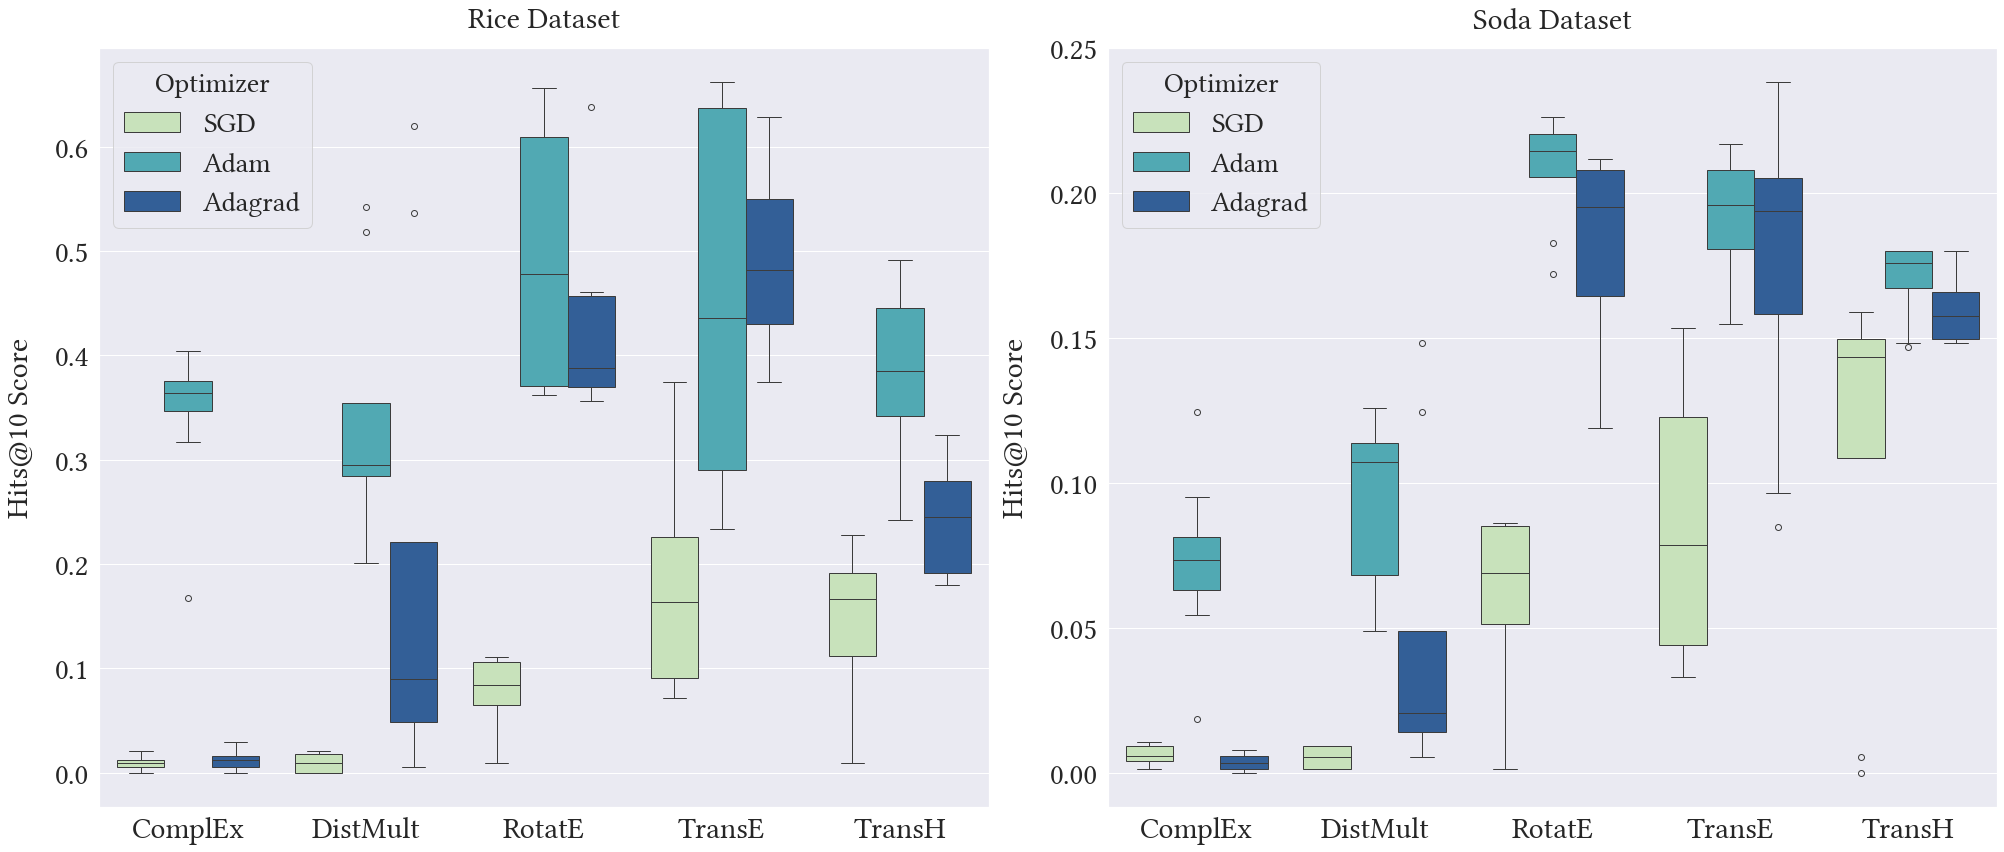

In [ ]:

# Distribution of Hits@10 Scores Across All Models and Optimizers'

plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.weight"] = "normal"

# Your existing code for creating subplots and plotting
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

sns.boxplot(x='model', y='score', hue='optimizer', data=hits_10_data_rice, palette="YlGnBu", ax=axes[0])
axes[0].set_title('Rice Dataset', fontsize=30, pad=20,)
axes[0].set_xlabel('')
axes[0].set_ylabel('Hits@10 Score', fontsize=30, labelpad=20)
axes[0].legend(title='Optimizer', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

sns.boxplot(x='model', y='score', hue='optimizer', data=hits_10_data_soda, palette="YlGnBu", ax=axes[1])
axes[1].set_title('Soda Dataset', fontsize=30, pad=20,)
axes[1].set_xlabel('')
axes[1].set_ylabel('Hits@10 Score', fontsize=30, labelpad=20)
axes[1].legend(title='Optimizer', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

plt.savefig('./plots/hits@10_across_all_models_and_optimizers.eps', format='eps', bbox_inches='tight')
plt.tight_layout()
plt.show()

Plot: Distribution of Hits@10 scores across all models and loss functions (Fig 4.3b)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


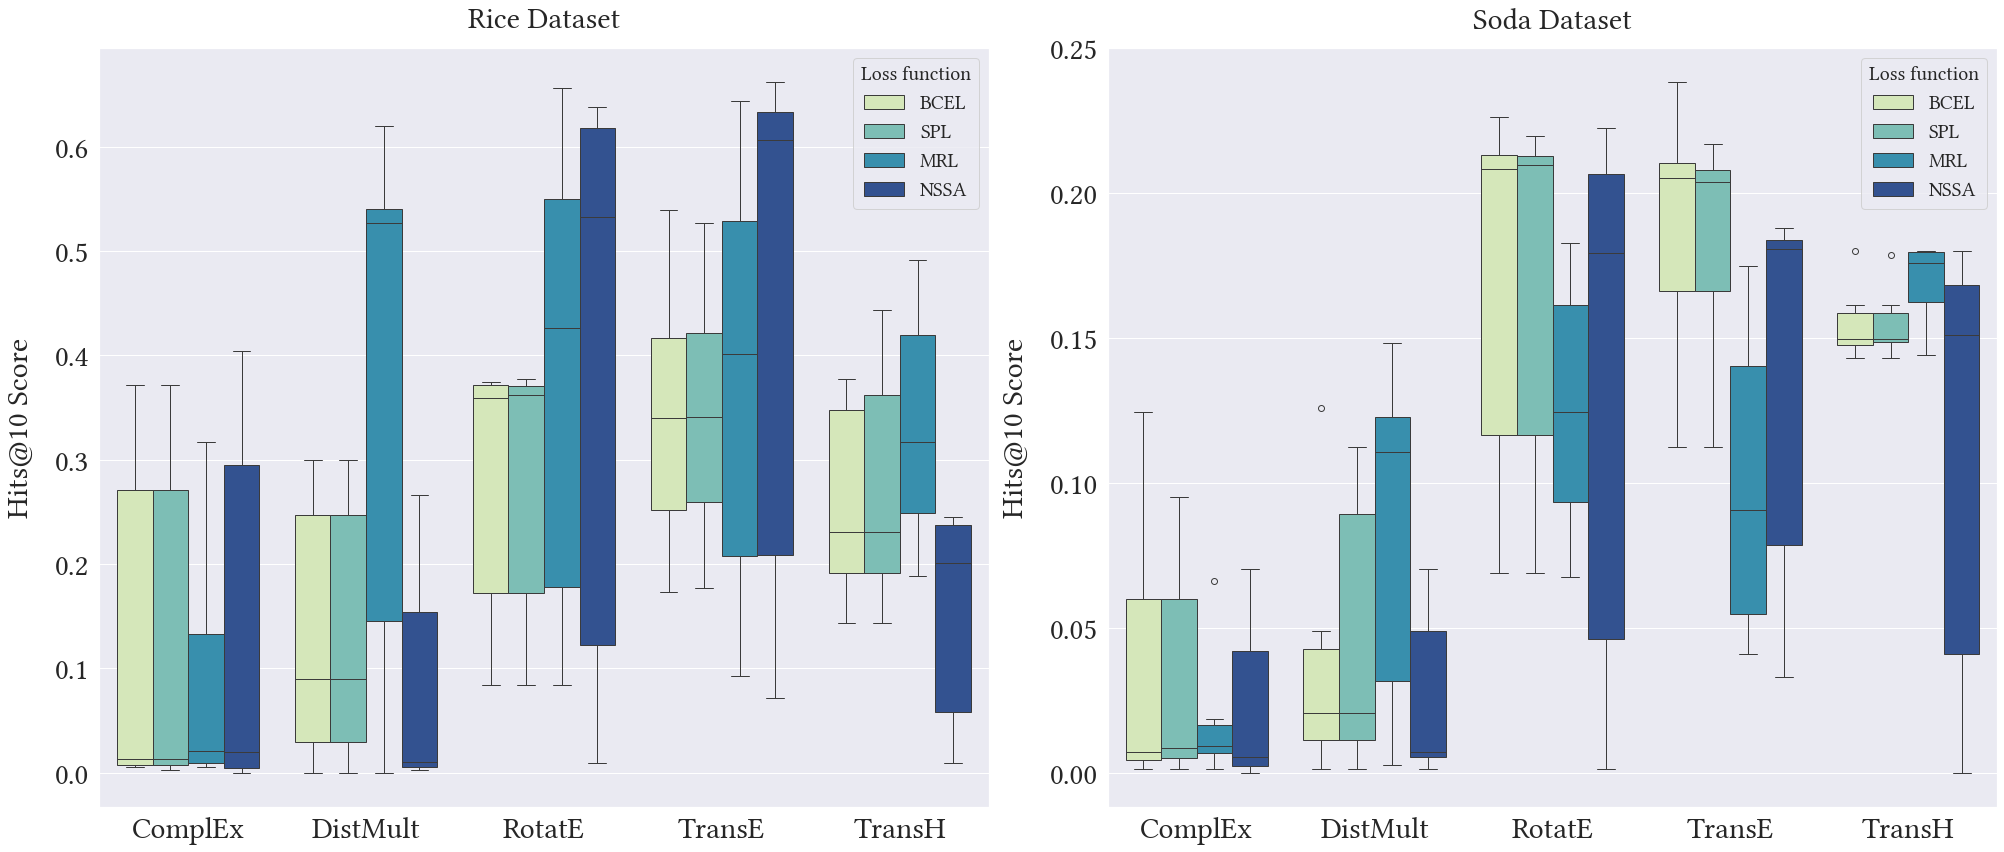

In [ ]:
# Distribution of Hits@10 Scores Across Models and Loss Functions

plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.weight"] = "normal"

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

# Plot the first graph
sns.boxplot(x='model', y='score', hue='loss', data=hits_10_data_rice, palette="YlGnBu", ax=axes[0])
axes[0].set_title('Rice Dataset', fontsize=30, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Hits@10 Score', fontsize=30, labelpad=20)
axes[0].legend(title='Loss function', title_fontproperties={'family':"Linux Libertine", 'size':20}, prop={'family':"Linux Libertine", 'size':20})

# Plot the second graph
sns.boxplot(x='model', y='score', hue='loss', data=hits_10_data_soda, palette="YlGnBu", ax=axes[1])
axes[1].set_title('Soda Dataset', fontsize=30, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Hits@10 Score', fontsize=30, labelpad=20)
axes[1].legend(title='Loss function', title_fontproperties={'family':"Linux Libertine", 'size':20}, prop={'family':"Linux Libertine", 'size':20})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

plt.savefig('./plots/hits@10_across_all_models_and_loss_functions.eps', format='eps', bbox_inches='tight')

plt.tight_layout()
plt.show()

Plot: Distribution of Hits@10 scores across all models with inverse relations present or absent. (Fig 4.3c)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


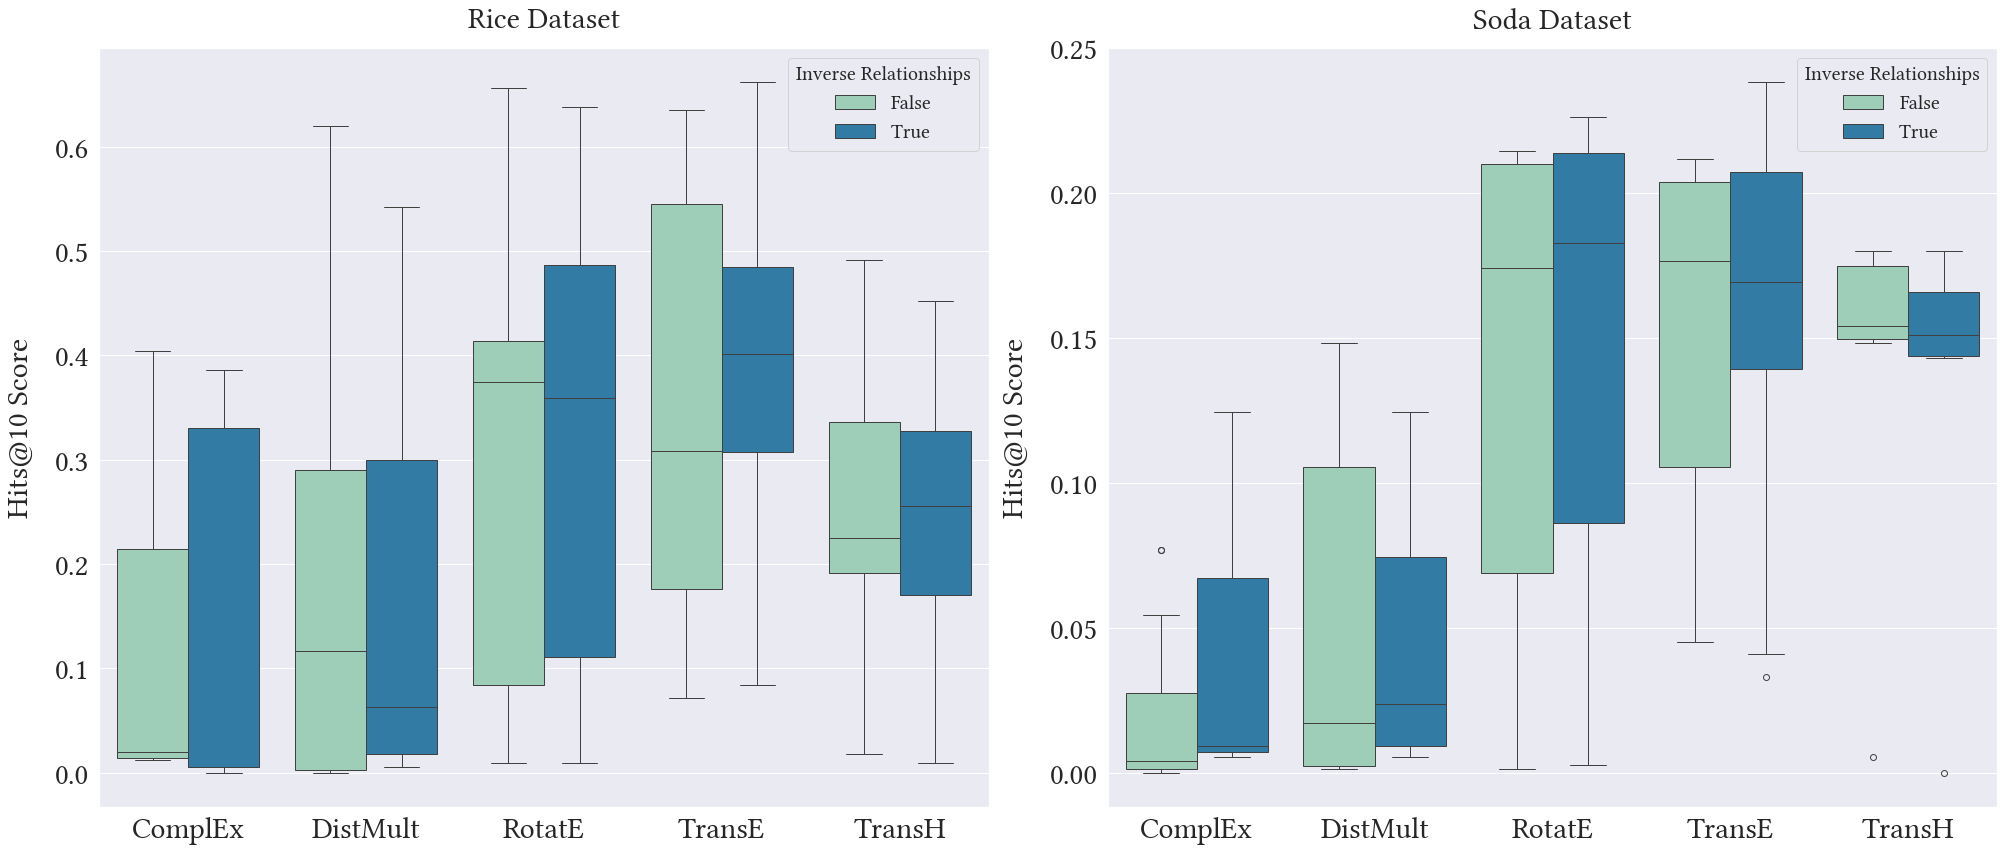

In [ ]:
# Distribution of Hits@10 Scores Across Models with inverse relations present or absent

plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.weight"] = "normal"

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

# Plot the first graph
sns.boxplot(x='model', y='score', hue='inverse_relations', data=hits_10_data_rice, palette="YlGnBu", ax=axes[0])
axes[0].set_title('Rice Dataset', fontsize=30, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Hits@10 Score', fontsize=30, labelpad=20)
axes[0].legend(title='Inverse Relationships', title_fontproperties={'family':"Linux Libertine", 'size':20}, prop={'family':"Linux Libertine", 'size':20})

# Plot the second graph
sns.boxplot(x='model', y='score', hue='inverse_relations', data=hits_10_data_soda, palette="YlGnBu", ax=axes[1])
axes[1].set_title('Soda Dataset', fontsize=30, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Hits@10 Score', fontsize=30, labelpad=20)
axes[1].legend(title='Inverse Relationships', title_fontproperties={'family':"Linux Libertine", 'size':20}, prop={'family':"Linux Libertine", 'size':20})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

plt.savefig('./plots/hits@10_across_all_models_with_inverse_relations_present_or_absent.eps', format='eps', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [ ]:
# TODO: Read this https://cthoyt.com/2020/12/11/inverse-triple-scoring.html